# Azure MVAD Service Guide - Part III (Visualizations)

What follows is a guide via example on how to use Azure's MVAD Service. Make sure to check the service's documentation [here](https://learn.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/overview), as well as the code provided [here](https://github.com/Azure-Samples/AnomalyDetector). Note that there are two approaches to using the MVAD Service: via the SDK and via the API. Both approaches have been presented in previous notebooks. Here, we simply perform example visualizations using the results from the trained MVAD models.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The following library needs to be installed. Note that its installation can be attached to the startup of a specific cluster that runs the present notebook, or to a script that is activated whenever the cluster starts.

In [ ]:
#!pip install --upgrade azure-ai-anomalydetector

## Setup

First, we import the needed modules and then create a client for the anomaly detector service.

In [ ]:
from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.core.credentials import AzureKeyCredential

In [ ]:
ad_name = "REDACTED"
ANOMALY_DETECTOR_ENDPOINT= f"https://{ad_name}.cognitiveservices.azure.com/"
# The key is stored in the Vault for safety
SUBSCRIPTION_KEY = dbutils.secrets.get(scope = "anomdet", key = "adkey")

# Setup the AD client
ad_client = AnomalyDetectorClient(ANOMALY_DETECTOR_ENDPOINT, AzureKeyCredential(SUBSCRIPTION_KEY))

## Data

With the following cell's code, we retrieve the results from the batch inferences performed in the previous notebooks, as well as the original time-series data.

In [ ]:
# First load the original data from the Blob Storage
blobkey = dbutils.secrets.get(scope = "anomdet", key = "blobkey")
storage_name = "REDACTED"
container_name = "test-mvad"
data_file_name = "sample.csv"

spark.conf.set(f"fs.azure.account.key.{storage_name}.dfs.core.windows.net", blobkey)
df = spark.read.csv(f"abfss://{container_name}@{storage_name}.dfs.core.windows.net/{data_file_name}", inferSchema=True, header = True).toPandas()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
display(df.head())

timestamp,opticalLFiltered,opticalRFiltered,pumpPressure,rotational,vibrationHorizon
2021-02-18T13:50:00.000+0000,0.09391688834982063,0.081610582,0.9593658583144566,0.004735046793306885,0.9347845556551376
2021-02-18T14:00:00.000+0000,0.08763391964414748,0.08519213099999999,0.95770617764882,0.027995249906611428,0.9338749440381748
2021-02-18T14:10:00.000+0000,0.10873942929927302,0.117380384,0.9542035002357117,0.0494876081496989,0.9239416418963576
2021-02-18T14:20:00.000+0000,0.12701360365484193,0.145632013,0.9476006152469834,0.07905882243729474,0.944029789344303
2021-02-18T14:30:00.000+0000,0.1566276360228549,0.138405762,0.9510689206959236,0.08817170394715729,0.9236886437692932


In [ ]:
# This must be known beforehand
request_id = 'a07a46c0-e90a-11ed-91ea-0e91979c62ac'
anomaly_results = ad_client.get_multivariate_batch_detection_result(request_id)

The `anomaly_results` object now holds the results of the batch inference process, which are stored in a dict-like format in `anomaly_results['results']`. The results in a DataFrame format can be seen by running the following cell.

In [ ]:
adf = pd.DataFrame([{'timestamp': x['timestamp'], **x['value']} for x in anomaly_results.results])
adf['timestamp'] = pd.to_datetime(adf['timestamp'], utc=True)
adf

,timestamp,isAnomaly,severity,score,interpretation
0,2021-09-09 15:10:00+00:00,True,0.067947,0.116752,"[{'variable': 'vibrationHorizon', 'contributio..."
1,2021-09-09 15:20:00+00:00,True,0.096815,0.166356,"[{'variable': 'vibrationHorizon', 'contributio..."
2,2021-09-09 15:30:00+00:00,True,0.111642,0.191832,"[{'variable': 'vibrationHorizon', 'contributio..."
3,2021-09-09 15:40:00+00:00,True,0.102313,0.175803,"[{'variable': 'opticalRFiltered', 'contributio..."
4,2021-09-09 15:50:00+00:00,True,0.113587,0.195174,"[{'variable': 'rotational', 'contributionScore..."
...,...,...,...,...,...
765,2021-09-14 22:40:00+00:00,False,0.000000,0.015003,[]
766,2021-09-14 22:50:00+00:00,False,0.000000,0.015003,[]
767,2021-09-14 23:00:00+00:00,False,0.000000,0.015003,[]
768,2021-09-14 23:10:00+00:00,False,0.000000,0.015003,[]


## Visualizations

Note that the sample data provided consist of 5 features, so we will proceed by first visualizing the 5 time-series and project the detected anomalies on top of them. Also note that the problem of Multivariate Anomaly Detection concerns "collective" anomalies, i.e. does not check each feature individually, but rather all of them along with their correlations. This is why the same anomalies are detected in all graphs.

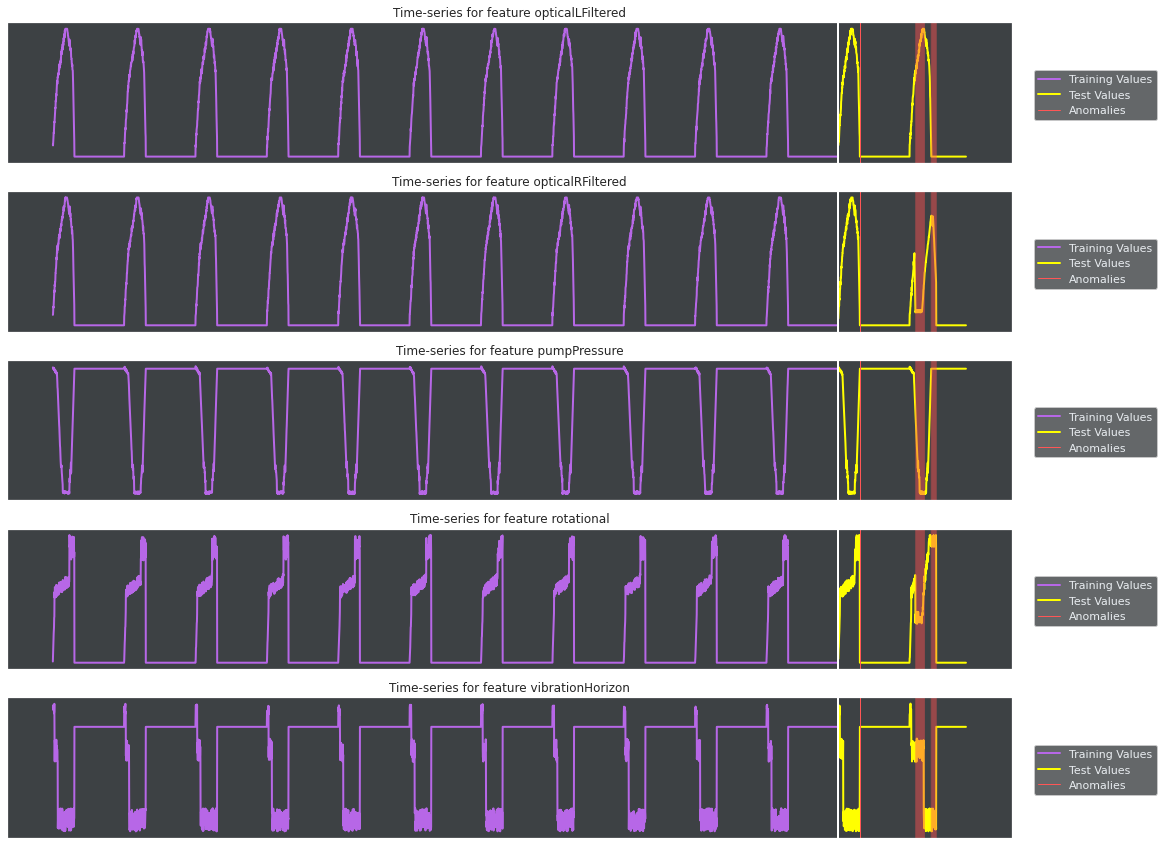

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(rc={'figure.figsize':(14.7,5.27)})

sns.set(rc={"grid.color": "#595d61", 'axes.facecolor':'#3d4144'})
cust_cols = {'test' : 'yellow', 'train' : '#B767e7', 'anomaly' : '#Ff5656'}

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18,15))

train_start = pd.to_datetime("2021-02-18T13:50:00Z")
idx_train_start = df.loc[df['timestamp'] == train_start].index.values[0]

train_end = pd.to_datetime("2021-03-23T10:00:00Z")
idx_train_end = df.loc[df['timestamp'] == train_end].index.values[0]

test_start = pd.to_datetime("2021-09-09T15:10:00Z")
idx_test_start = df.loc[df['timestamp'] == test_start].index.values[0]

test_end = pd.to_datetime("2021-09-14T23:20:00Z")
idx_test_end = df.loc[df['timestamp'] == test_end].index.values[0]

# Set a severity threshold for additional checking
severity_thresh = 0.2 # <- play with this value to see more/less anomalies

# Get the part of the data that corresponds to the training of the model
train_df = df.loc[df['timestamp'] <= train_end].loc[df['timestamp'] >= train_start]
# Get the part of the data that corresponds to the inference of the model
test_df = df.loc[df['timestamp'] <= test_end].loc[df['timestamp'] >= test_start]

anoms = list(adf.loc[adf['isAnomaly']==True].loc[adf['severity'] >= severity_thresh].index+idx_train_end)

for i in range(1,6):
    col = train_df.columns[i]

    # Note that +3, or +2 are added so that there is a small gap between train and test values

    # plot training data
    axes[i-1].plot(range(idx_train_start, idx_train_end+1), train_df[col].values, color=cust_cols['train'], linestyle='-', linewidth=2.0, label='Training Values')
    # plot test data
    axes[i-1].plot(range(idx_train_end+3, idx_train_end+3+len(test_df)), test_df[col].values, color=cust_cols['test'], linestyle='-', linewidth=2.0, label='Test Values')
    # plot the separator between train and test data
    axes[i-1].axvline(x=idx_train_end+2, ymin=0, ymax=1, linestyle='-', linewidth=2, color='white')
    # plot anomalies
    for idx, anom in enumerate(anoms):
        if idx==0:
            axes[i-1].axvline(x=anom+3, ymin=0, ymax=1, linestyle='-', linewidth=1, color=cust_cols['anomaly'], alpha=1.0, label='Anomalies')
        else:
            axes[i-1].axvline(x=anom+3, ymin=0, ymax=1, linestyle='-', linewidth=1, color=cust_cols['anomaly'], alpha=0.1)

    axes[i-1].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.15, 0.7))
    axes[i-1].set_title(f"Time-series for feature {col}")
    axes[i-1].set_xticklabels([])
    axes[i-1].set_xticks([])
    axes[i-1].set_yticklabels([])
    axes[i-1].set_yticks([])    

plt.show()

The above plot visualizes the time-series individually and depicts anomalous values with a red overlay. There are more detailed plots we can construct by using the information provided to us by the MVAD results API. For example, we can create a common plot for all 5 time-series and also depict the score and severity as calculated by the model, as well as each feature's contribution to the anomaly values (see `interpretation` column).

In [ ]:
# Get lists of all contributions per test point
# This is definitely not the optimal way to do this, but it's the easier one to understand when studying it
contribs = {}
for i in range(1,6):
    col = test_df.columns[i]
    contribs[col] = np.zeros(shape=len(adf))

for index, row in adf.iterrows():
    z = row['interpretation']
    if z:
        for var in z:
            contribs[var['variable']][index] = var['contributionScore']
    else:
        for key in contribs:
            contribs[key][index] = 0.0

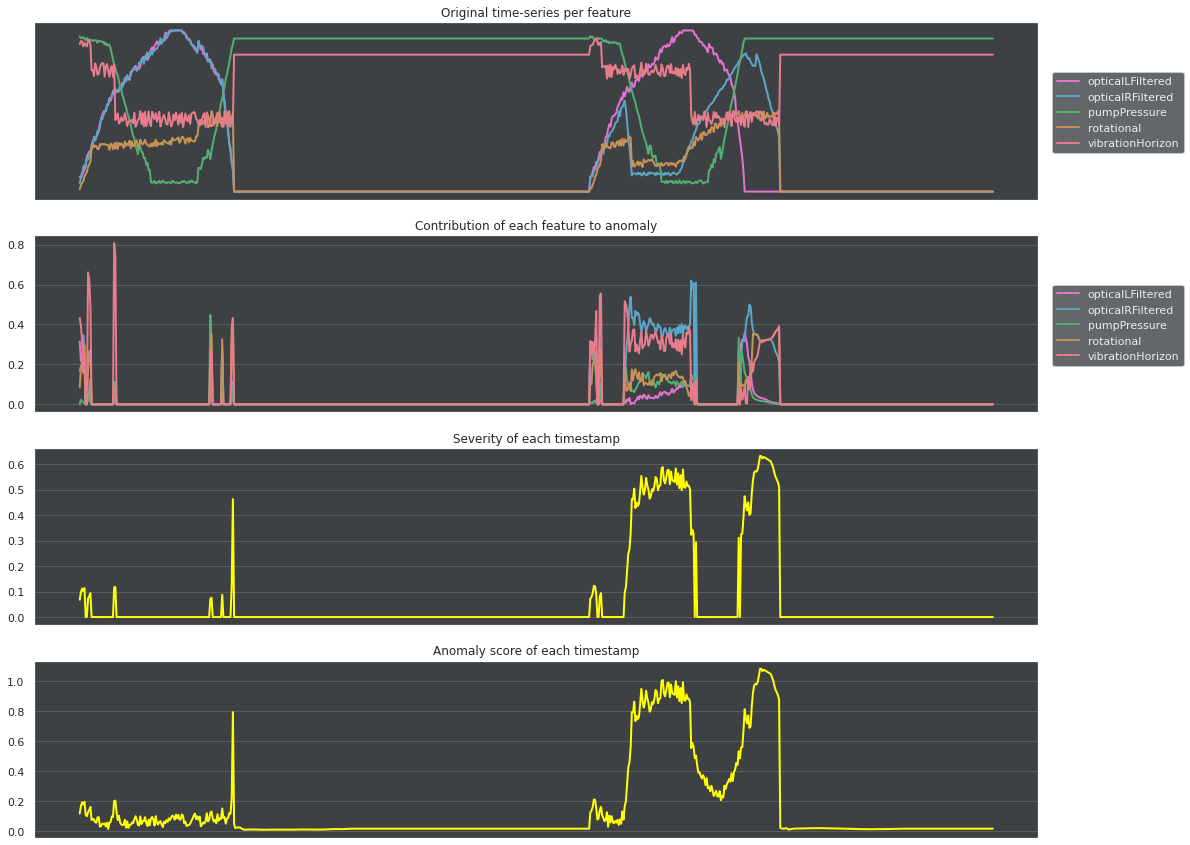

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(rc={'figure.figsize':(14.7,5.27)})

sns.set(rc={"grid.color": "#595d61", 'axes.facecolor':'#3d4144'})
cust_cols = {'test' : 'yellow', 'train' : '#B767e7', 'anomaly' : '#Ff5656'}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,15))

# Get the part of the data that corresponds to the training of the model
train_df = df.loc[df['timestamp'] <= train_end].loc[df['timestamp'] >= train_start]
# Get the part of the data that corresponds to the inference of the model
test_df = df.loc[df['timestamp'] <= test_end].loc[df['timestamp'] >= test_start]

anoms = list(adf.loc[adf['isAnomaly']==True].loc[adf['severity'] >= severity_thresh].index+idx_train_end)
cols = ['#e274cf', '#5ea5c5', '#56ad74', '#c69255', '#e77c8d']

# Plot the original time-series with colors depending on contribution
for i in range(1,6):
    col = test_df.columns[i]
    axes[0].plot(range(len(test_df)), test_df[col].values, color=cols[i-1], linestyle='-', linewidth=2.0, label=col)
    cont = contribs[col]
    axes[1].plot(range(len(cont)), cont, color=cols[i-1], linestyle='-', linewidth=2.0, label=col)

axes[0].set_title('Original time-series per feature')
axes[0].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.15, 0.75))
axes[0].set_yticklabels([])
axes[0].set_yticks([])

axes[1].set_title('Contribution of each feature to anomaly')
axes[1].legend(labelcolor='#E9edf1', bbox_to_anchor=(1.15, 0.75))

axes[2].plot(range(len(test_df)), adf['severity'].values, color='yellow', linestyle='-', linewidth=2.0)
axes[2].set_title('Severity of each timestamp')

axes[3].plot(range(len(test_df)), adf['score'].values, color='yellow', linestyle='-', linewidth=2.0)
axes[3].set_title('Anomaly score of each timestamp')
    
for i in range(4):
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])

plt.show()

Note that these visualizations are not exhaustive, but simply representative of the kind of information we can get from the MVAD models' inference results.